In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import scipy
import SimpleITK as sitk
import numpy as np
import os
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import describe_sitk
Console_and_file_logger('temp tests')

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2020-07-06 18:13:43,293 INFO -------------------- Start --------------------
2020-07-06 18:13:43,307 INFO Working directory: /mnt/data/git/cardio.
2020-07-06 18:13:43,307 INFO Log file: ./logs/temp tests.log
2020-07-06 18:13:43,307 INFO Log level for console: INFO


In [2]:
# Define a path to an 3D AX image
from ipyfilechooser import FileChooser
ax_chooser = FileChooser(os.path.join(os.getcwd(),'data/raw/gcn_05_2020_ax_sax_86/AX_3D'), '')
display(ax_chooser)

FileChooser(path='/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D', filename='', show_hidden='False'…

In [3]:
# Define a path to an 3D AX image
from ipyfilechooser import FileChooser
sax_chooser = FileChooser(os.path.join(os.getcwd(),'data/raw/gcn_05_2020_ax_sax_86/SAX_3D'), '')
display(sax_chooser)

FileChooser(path='/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/SAX_3D', filename='', show_hidden='False…

ax shape: (20, 256, 256)
sax shape: (14, 256, 256)


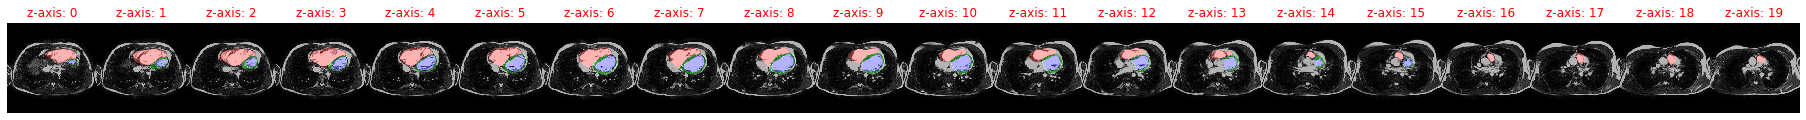

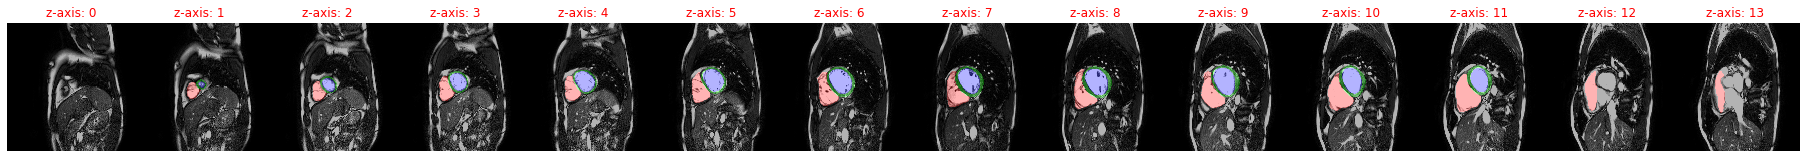

2020-06-25 09:31:28,204 INFO size: (256, 256, 20)
2020-06-25 09:31:28,204 INFO spacing: (1.3671875, 1.3671875, 5.69999980926513)
2020-06-25 09:31:28,205 INFO origin: (-173.77551019191, -169.82195615768, -62.506076812744)
2020-06-25 09:31:28,205 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-25 09:31:28,206 INFO pixel type: 32-bit float
2020-06-25 09:31:28,206 INFO number of pixel components: 1
2020-06-25 09:31:28,206 INFO ****************************************
2020-06-25 09:31:28,206 INFO size: (256, 256, 14)
2020-06-25 09:31:28,207 INFO spacing: (1.3671875, 1.3671875, 8.800000190734862)
2020-06-25 09:31:28,207 INFO origin: (155.465412557125, -203.09131520986, 111.241161063313)
2020-06-25 09:31:28,207 INFO direction: (0.26886075697713174, -0.587623112065609, -0.7631598597436925, 0.9431801558774483, 0.0, 0.33228179841663347, -0.19525646446833947, -0.8091347713244863, 0.5542344584352323)
2020-06-25 09:31:28,207 INFO pixel type: 32-bit float
2020-06-25 09:31:28,20

In [65]:
# load and show both volumes
ax_sitk = sitk.ReadImage(ax_chooser.selected)
ax_msk_sitk = sitk.ReadImage(ax_chooser.selected.replace('img','msk'))
sax_sitk = sitk.ReadImage(sax_chooser.selected)
sax_msk_sitk = sitk.ReadImage(sax_chooser.selected.replace('img','msk'))

# get nda from ax/sax
ax_nda = sitk.GetArrayFromImage(ax_sitk)
sax_nda = sitk.GetArrayFromImage(sax_sitk)

print ('ax shape: {}'.format(ax_nda.shape))
print ('sax shape: {}'.format(sax_nda.shape))

show_2D_or_3D(ax_sitk, ax_msk_sitk)
show_2D_or_3D(sax_sitk, sax_msk_sitk)
plt.show()
describe_sitk(ax_sitk)
logging.info('*'*40)
describe_sitk(sax_sitk)

# Resample with sitk

In [92]:
# different resample possibilities with sitk
from src.data.Dataset import get_metadata_maybe, ensure_dir

def resample_with_reference(sitk_img, reference_sitk, interpolate=sitk.sitkBSpline):
    """
        Resample a sitk img with a reference sitk image
        :param sitk_img: sitk.Image
        :param reference_sitk: sitk.Image
        :param interpolate: fn
        :return: 
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_sitk)
    resampler.SetInterpolator(interpolate)
    resampled = resampler.Execute(sitk_img)
    # copy metadata
    for key in reference_sitk.GetMetaDataKeys():
        resampled.SetMetaData(key, get_metadata_maybe(reference_sitk, key))
    return resampled

def resample_direcion_origin_spacing_flexible_size(sitk_img, reference_sitk, interpolate=sitk.sitkBSpline):
    """
    Resample a sitk img, copy direction, origin and spacing of the reference image
    Keep calculate the new size of z by (x_size_target*x_spacing_target)/z_spacing_reference to avoid cutting
    :param sitk_img: sitk.Image
    :param reference_sitk: sitk.Image
    :param interpolate: fn
    :return: 
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(reference_sitk.GetSpacing())
    resampler.SetInterpolator(interpolate)
    resampler.SetOutputDirection(reference_sitk.GetDirection())
    resampler.SetOutputOrigin(reference_sitk.GetOrigin())
    target_size = sitk_img.GetSize()
    reference_size = reference_sitk.GetSize()
    # get the physical size along x (left to right) of the axial/target image, dive it by the reference/sax image spacing in z
    new_z = int((sitk_img.GetSize()[0] * sitk_img.GetSpacing()[0])//reference_sitk.GetSpacing()[-1])
    resampler.SetSize((target_size[0],target_size[1], new_z))
    resampled = resampler.Execute(sitk_img)
    # copy metadata
    for key in reference_sitk.GetMetaDataKeys():
        resampled.SetMetaData(key, get_metadata_maybe(reference_sitk, key))
    return resampled

def resample_direcion_origin_spacing(sitk_img, reference_sitk, interpolate=sitk.sitkBSpline):
    """
    Resample a sitk img, copy direction, origin and spacing of the reference image
    Keep the size (resolution) of the target image
    :param sitk_img: sitk.Image
    :param reference_sitk: sitk.Image
    :param interpolate: fn
    :return: 
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(reference_sitk.GetSpacing())
    resampler.SetInterpolator(interpolate)
    resampler.SetOutputDirection(reference_sitk.GetDirection())
    resampler.SetOutputOrigin(reference_sitk.GetOrigin())
    resampler.SetSize(sitk_img.GetSize())
    resampled = resampler.Execute(sitk_img)
    # copy metadata
    for key in reference_sitk.GetMetaDataKeys():
        resampled.SetMetaData(key, get_metadata_maybe(reference_sitk, key))
    return resampled

def resample_direction_origin(sitk_img, reference_sitk, interpolate=sitk.sitkBSpline):
    """
    Resample a sitk img, copy direction and origin of the reference sitk image
    :param sitk_img: sitk.Image
    :param reference_sitk: sitk.Image
    :param interpolate: fn
    :return: 
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(sitk_img.GetSpacing())
    resampler.SetInterpolator(interpolate)
    resampler.SetOutputDirection(reference_sitk.GetDirection())
    resampler.SetOutputOrigin(reference_sitk.GetOrigin())
    resampler.SetSize(sitk_img.GetSize())
    resampled = resampler.Execute(sitk_img)
    # copy metadata
    for key in reference_sitk.GetMetaDataKeys():
        resampled.SetMetaData(key, get_metadata_maybe(reference_sitk, key))
    return resampled

def resample_isotrop_direcion_origin(sitk_img, reference_sitk, interpolate=sitk.sitkBSpline,new_spacing=(1.,1.,1.)):
    """
    Resample a sitk img, copy direction, origin and resample to a spacing of 1,1,1 of the reference image
    Keep the size (resolution) of the target image
    :param sitk_img: sitk.Image
    :param reference_sitk: sitk.Image
    :param interpolate: fn
    :return: 
    """
    
    size = sitk_img.GetSize()
    spacing = sitk_img.GetSpacing()
    size_new = tuple([int((s*p)//space_new) for s,space_old,space_new in zip(size,spacing,new_spacing)])
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetInterpolator(interpolate)
    resampler.SetOutputDirection(reference_sitk.GetDirection())
    resampler.SetOutputOrigin(reference_sitk.GetOrigin())
    resampler.SetSize(size_new)
    resampled = resampler.Execute(sitk_img)
    # copy metadata
    for key in reference_sitk.GetMetaDataKeys():
        resampled.SetMetaData(key, get_metadata_maybe(reference_sitk, key))
    return resampled

In [93]:
def resample_copy_meta_save(target_files, reference_files, res_fn=resample_direcion_origin_spacing, export_dir='data/temp/'):
    """
    Helper to resample two list of files
    :param target_files: list of nrrd/dicom files
    :param reference_files: list of nrrd/dicom files
    :param res_fn: resample strategy/function, callable with the signature sitk.Image, sitk.Image
    :param export_dir: (str) export root path
    :return: none
    """
    
    ensure_dir(export_dir)
    assert(len(target_files)==len(reference_files)), 'len(target_list) != len(reference_list)'

    for target, reference in zip(target_files, reference_files):
        f_name = os.path.basename(target)
        target_f_name = os.path.join(export_dir, f_name)
        logging.info('file: {}'.format(target_f_name))
        resampled = res_fn(sitk.ReadImage(target), sitk.ReadImage(reference))
        sitk.WriteImage(resampled, target_f_name)
        
def transform_to_isotrop_voxels(sitk_img, interpolate=sitk.sitkBSpline, new_spacing=(1.,1.,1.)):

    size = sitk_img.GetSize()
    spacing = sitk_img.GetSpacing()
    size_new = tuple([int((s*p)//space_new) for s,space_old,space_new in zip(size,spacing,new_spacing)])

    # resample to isotrop voxels
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(size_new)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputOrigin(sitk_img.GetOrigin())
    resampler.SetOutputDirection(sitk_img.GetDirection())
    resampler.SetInterpolator(interpolate)
    return resampler.Execute(sitk_img)

In [94]:
# select a resample strategy/function, resample all files of two lists
resample_fn = resample_direcion_origin_spacing
resample_copy_meta_save(ax_files, sax_files, res_fn=resample_fn, export_dir='data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/')

2020-06-25 17:19:29,968 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0HQQW4ZN_2007-05-23_ED_img.nrrd
2020-06-25 17:19:30,074 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd
2020-06-25 17:19:30,173 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0HQQW4ZN_2007-05-23_ES_img.nrrd
2020-06-25 17:19:30,276 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd
2020-06-25 17:19:30,380 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0PTV75MP_2005-06-27_ED_img.nrrd
2020-06-25 17:19:30,456 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0PTV75MP_2005-06-27_ED_msk.nrrd
2020-06-25 17:19:30,527 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0PTV75MP_2005-06-27_ES_img.nrrd
2020-06-25 17:19:30,605 INFO file: data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_no_crop/0000-0PTV75MP_2005-06-27_ES_msk.nrrd
2020-06-

In [90]:
ax_files = sorted(glob.glob('data/raw/gcn_05_2020_ax_sax_86/AX_3D/*.nrrd'))
print('ax files: {}'.format(len(ax_files)))

ax files: 324


In [91]:
sax_files = sorted(glob.glob('data/raw/gcn_05_2020_ax_sax_86/SAX_3D_ED_ES/*.nrrd'))
print('sax files: {}'.format(len(sax_files)))

sax files: 324


## Resample one image with respect to a second image space

In [73]:
@interact_manual
def resample_interact(ax_file = ax_files, sax_file = sax_files):
    """
    Select an AX and SAX 3D volume.
    Resample the first image with respect to the second image.
    Apply and visualise different resample strategies.
     
    :param ax_file: (str) full filename to a sitk image
    :param sax_file: (str) full filename to a sitk image
    :return: none
    """
    print('Resample : \n{}\nWith respect to: \n{}'.format(ax_file, sax_file))
    ax_sitk = sitk.ReadImage(ax_file)
    ax_msk_sitk = sitk.ReadImage(ax_file.replace('img','msk'))
    sax_sitk = sitk.ReadImage(sax_file)
    sax_msk_sitk = sitk.ReadImage(sax_file.replace('img','msk'))
    
    print ('ax shape: {}'.format(ax_nda.shape))
    print ('sax shape: {}'.format(sax_nda.shape))

    show_2D_or_3D(ax_sitk, ax_msk_sitk)
    show_2D_or_3D(sax_sitk, sax_msk_sitk)
    plt.show()
    describe_sitk(ax_sitk)
    logging.info('*'*40)
    describe_sitk(sax_sitk)
    
    print('*'*60, '\n')
    print('Resample - with reference image, copy all parameters')
    temp = resample_with_reference(ax_sitk,sax_sitk,sitk.sitkLinear)
    show_2D_or_3D(temp)
    plt.show()
    print('Resample - with reference image, copy all parameters')
    print('AX size : {}'.format(ax_sitk.GetSize()))
    print('SAX size: {} '.format(sax_sitk.GetSize()))
    print('Resampled size: {}'.format(temp.GetSize()))
    print('-'*20)
    print('AX spacing : {}'.format(ax_sitk.GetSpacing()))
    print('SAX spacing: {} '.format(sax_sitk.GetSpacing()))
    print('Resampled spacing: {}'.format(temp.GetSpacing()))

    print('*'*60, '\n')
    print('Resample - copy direction and origin, keep spacing and size')
    temp = resample_direction_origin(ax_sitk,sax_sitk,sitk.sitkLinear)
    show_2D_or_3D(temp)
    plt.show()
    print('AX size : {}'.format(ax_sitk.GetSize()))
    print('SAX size: {} '.format(sax_sitk.GetSize()))
    print('Resampled size: {}'.format(temp.GetSize()))
    print('-'*20)
    print('AX spacing : {}'.format(ax_sitk.GetSpacing()))
    print('SAX spacing: {} '.format(sax_sitk.GetSpacing()))
    print('Resampled spacing: {}'.format(temp.GetSpacing()))

    
    print('*'*60, '\n')
    print('Resample to isotrop voxels - copy direction, origin and spacing, keep size')
    temp = resample_isotrop_direcion_origin(ax_sitk,sax_sitk,sitk.sitkLinear)
    show_2D_or_3D(sitk.GetArrayFromImage(temp)[::10])
    plt.show()
    print('AX size : {}'.format(ax_sitk.GetSize()))
    print('SAX size: {} '.format(sax_sitk.GetSize()))
    print('Resampled size: {}'.format(temp.GetSize()))
    print('-'*20)
    print('AX spacing : {}'.format(ax_sitk.GetSpacing()))
    print('SAX spacing: {} '.format(sax_sitk.GetSpacing()))
    print('Resampled spacing: {}'.format(temp.GetSpacing()))
    

    
    print('*'*60, '\n')
    print('Resample - copy direction, origin and spacing, keep size')
    temp = resample_direcion_origin_spacing(ax_sitk,sax_sitk,sitk.sitkLinear)
    show_2D_or_3D(temp)
    plt.show()
    print('AX size : {}'.format(ax_sitk.GetSize()))
    print('SAX size: {} '.format(sax_sitk.GetSize()))
    print('Resampled size: {}'.format(temp.GetSize()))
    print('-'*20)
    print('AX spacing : {}'.format(ax_sitk.GetSpacing()))
    print('SAX spacing: {} '.format(sax_sitk.GetSpacing()))
    print('Resampled spacing: {}'.format(temp.GetSpacing()))
    
    print('*'*60, '\n')
    print('Resample - copy direction, origin and spacing, calculate size of z')
    temp = resample_direcion_origin_spacing_flexible_size(ax_sitk,sax_sitk,sitk.sitkLinear)
    show_2D_or_3D(temp)
    plt.show()
    print('AX size : {}'.format(ax_sitk.GetSize()))
    print('SAX size: {} '.format(sax_sitk.GetSize()))
    print('Resampled size: {}'.format(temp.GetSize()))
    print('-'*20)
    print('AX spacing : {}'.format(ax_sitk.GetSpacing()))
    print('SAX spacing: {} '.format(sax_sitk.GetSpacing()))
    print('Resampled spacing: {}'.format(temp.GetSpacing()))
    

interactive(children=(Dropdown(description='ax_file', options=('data/raw/gcn_05_2020_ax_sax_86/AX_3D/0000-0HQQ…

2020-06-25 09:32:59,408 INFO size: (350, 350, 113)
2020-06-25 09:32:59,409 INFO spacing: (1.0, 1.0, 1.0)
2020-06-25 09:32:59,409 INFO origin: (-173.77551019191, -169.82195615768, -62.506076812744)
2020-06-25 09:32:59,409 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-25 09:32:59,410 INFO pixel type: 32-bit float
2020-06-25 09:32:59,410 INFO number of pixel components: 1


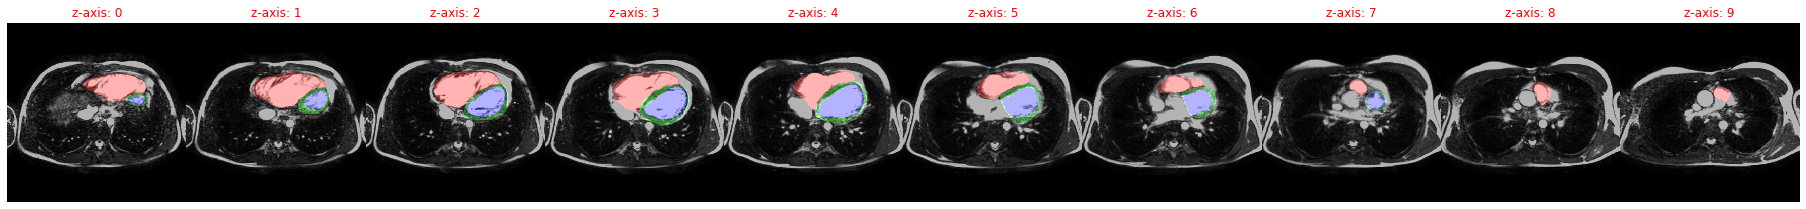

2020-06-25 09:33:00,034 INFO size: (350, 350, 123)
2020-06-25 09:33:00,034 INFO spacing: (1.0, 1.0, 1.0)
2020-06-25 09:33:00,035 INFO origin: (155.465412557125, -203.09131520986, 111.241161063313)
2020-06-25 09:33:00,035 INFO direction: (0.26886075697713174, -0.587623112065609, -0.7631598597436925, 0.9431801558774483, 0.0, 0.33228179841663347, -0.19525646446833947, -0.8091347713244863, 0.5542344584352323)
2020-06-25 09:33:00,036 INFO pixel type: 32-bit float
2020-06-25 09:33:00,036 INFO number of pixel components: 1


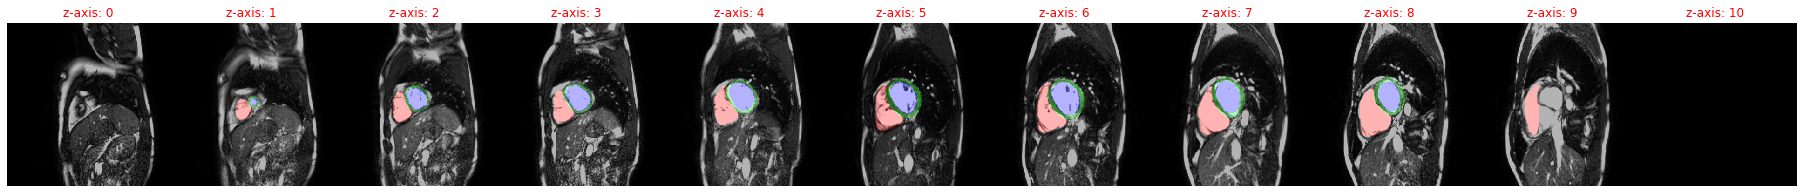

In [69]:
# get nda from both
import SimpleITK as sitk
from scipy.ndimage import affine_transform

def transform_to_isotrop_voxels(sitk_img, interpolate=sitk.sitkBSpline):
    
    size = sitk_img.GetSize()
    spacing = sitk_img.GetSpacing()
    size_new = tuple([int(s*p) for s,p in zip(size,spacing)])
    
    # resample to isotrop voxels
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(size_new)
    resampler.SetOutputSpacing((1.,1.,1.))
    resampler.SetOutputOrigin(sitk_img.GetOrigin())
    resampler.SetOutputDirection(sitk_img.GetDirection())
    resampler.SetInterpolator(interpolate)
    return resampler.Execute(sitk_img)

# ax
ax_resampled =transform_to_isotrop_voxels(ax_sitk, interpolate=sitk.sitkLinear)
ax_nda = sitk.GetArrayFromImage(ax_resampled)
# sax
sax_resampled =transform_to_isotrop_voxels(sax_sitk, interpolate=sitk.sitkLinear)
sax_nda = sitk.GetArrayFromImage(sax_resampled)
# ax mask
ax_msk_resampled = transform_to_isotrop_voxels(ax_msk_sitk, interpolate=sitk.sitkNearestNeighbor)
ax_msk_nda = sitk.GetArrayFromImage(ax_msk_resampled)
# sax mask
sax_msk_resampled = transform_to_isotrop_voxels(sax_msk_sitk, interpolate=sitk.sitkNearestNeighbor)
sax_msk_nda = sitk.GetArrayFromImage(sax_msk_resampled)

show_2D_or_3D(ax_nda[::12], ax_msk_nda[::12])
describe_sitk(ax_resampled)
plt.show()
show_2D_or_3D(sax_nda[::12], sax_msk_nda[::12])
describe_sitk(sax_resampled)

In [351]:
# calculate extremas for new origin
extreme_points = [ax_resampled.TransformIndexToPhysicalPoint((0,0,0)), #lower left, front
                  ax_resampled.TransformIndexToPhysicalPoint((ax_resampled.GetWidth(),0,0)), # lower right, front
                  ax_resampled.TransformIndexToPhysicalPoint((ax_resampled.GetWidth(),ax_resampled.GetHeight(),0)), # top right, front
                  ax_resampled.TransformIndexToPhysicalPoint((0,ax_resampled.GetHeight(),0)), # top left, front
                  ax_resampled.TransformIndexToPhysicalPoint((0,0,ax_resampled.GetDepth())), # lower left, back
                  ax_resampled.TransformIndexToPhysicalPoint((ax_resampled.GetWidth(),0,ax_resampled.GetDepth())), # lower right, back
                  ax_resampled.TransformIndexToPhysicalPoint((0,ax_resampled.GetHeight(),ax_resampled.GetDepth())), # top left, back
                  ax_resampled.TransformIndexToPhysicalPoint((ax_resampled.GetWidth(),ax_resampled.GetHeight(),ax_resampled.GetDepth())), # lower right, back
                 ]
print(extreme_points)
direction = np.linalg.inv(get_direction_as_translationmatrix(sax_sitk))
moved_extrema = [direction.dot(p) for p in extreme_points]
print(moved_extrema)
min_x = min(moved_extrema, key=lambda p: p[0])[0]
min_y = min(moved_extrema, key=lambda p: p[1])[1]
min_z = min(moved_extrema, key=lambda p: p[2])[2]
print((min_x, min_y, min_z))

[(-140.8435883522, -117.89342880249, -28.524059295654), (129.1564116478, -117.89342880249, -28.524059295654), (129.1564116478, 152.10657119751, -28.524059295654), (-140.8435883522, 152.10657119751, -28.524059295654), (-140.8435883522, -117.89342880249, 91.475940704346), (129.1564116478, -117.89342880249, 91.475940704346), (-140.8435883522, 152.10657119751, 91.475940704346), (129.1564116478, 152.10657119751, 91.475940704346)]
[array([ -69.2312003 ,  138.32077112, -103.07183939]), array([  49.55576037, -101.86560412, -136.24054645]), array([ 122.16978163, -101.86560412,  123.81176351]), array([  3.38282096, 138.32077112, 156.98047057]), array([-172.04769693,   83.50704813,  -74.36254135]), array([ -53.26073626, -156.6793271 , -107.53124841]), array([-99.43367566,  83.50704813, 185.68976861]), array([  19.353285  , -156.6793271 ,  152.52106155])]
(-172.04769692865386, -156.679327102261, -136.24054644617328)


shape after cubic padding: (349, 350, 350)
shape after cubic padding: (349, 350, 350)
target image paded


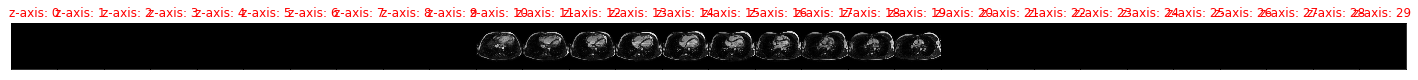

reference image paded


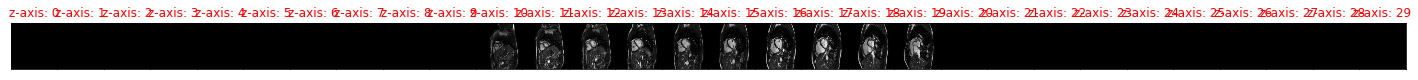

origin: [ 111.24116106 -203.09131521  155.46541256]
direction: [[ 0.55423446 -0.80913477 -0.19525646]
 [ 0.3322818   0.          0.94318016]
 [-0.76315986 -0.58762311  0.26886076]]
new origin: [195.62630274 183.59530511  76.24491031]
new - old: [154.38514168 386.68662032  70.77949775]
before transform shape: (349, 350, 350)
after transform shape: (349, 350, 350)
target image


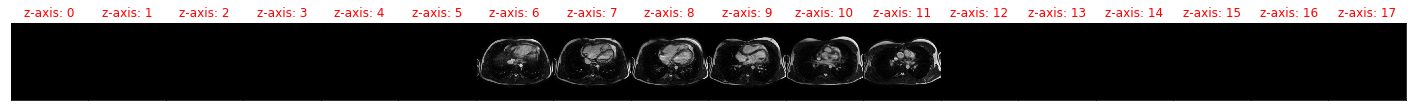

transformed target image


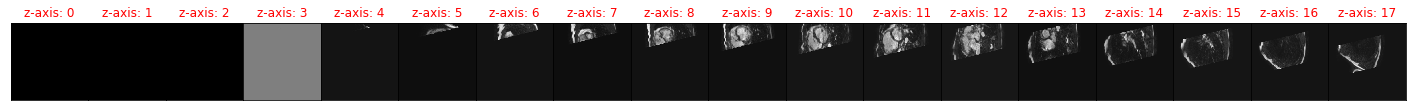

reference image


2020-06-25 09:23:32,604 INFO size: (350, 350, 349)
2020-06-25 09:23:32,604 INFO spacing: (1.0, 1.0, 1.0)
2020-06-25 09:23:32,605 INFO origin: (0.0, 0.0, 0.0)
2020-06-25 09:23:32,605 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-25 09:23:32,606 INFO pixel type: 32-bit float
2020-06-25 09:23:32,606 INFO number of pixel components: 1


cut z by an offset of: 46
(297, 350, 350)


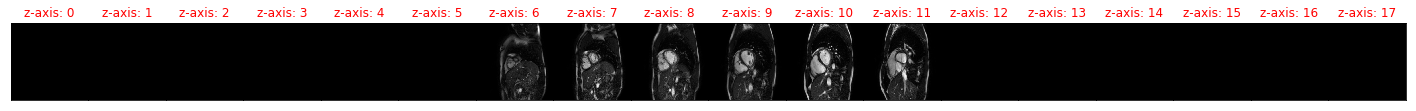

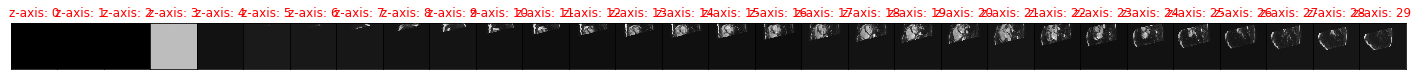

In [64]:
# apply transformation
transformed = apply_direction(sax_resampled, ax_resampled, list(reversed(ax_sitk.GetSize())))

In [167]:
# write resampled sitk image to disk
writer = sitk.ImageFileWriter()
writer.SetFileName('data/interim/temp.dcm')
writer.Execute(ax_sitk)

In [86]:
rot = np.identity(3)
print(rot.shape)
trans = np.zeros((3,1))
print(trans.shape)
np.concatenate([rot,trans],axis=1)

(3, 3)
(3, 1)


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

[[ 0.43995171 -0.88957917 -0.12284706]
 [ 0.26894082  0.          0.9631567 ]
 [-0.85680414 -0.45678102  0.23924415]]


2020-06-18 08:49:32,858 INFO size: (270, 270, 120)
2020-06-18 08:49:32,858 INFO spacing: (1.0, 1.0, 1.0)
2020-06-18 08:49:32,858 INFO origin: (0.0, 0.0, 0.0)
2020-06-18 08:49:32,859 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-18 08:49:32,859 INFO pixel type: 32-bit float
2020-06-18 08:49:32,859 INFO number of pixel components: 1


before transform shape: (120, 270, 270)
after transform shape: (120, 270, 270)


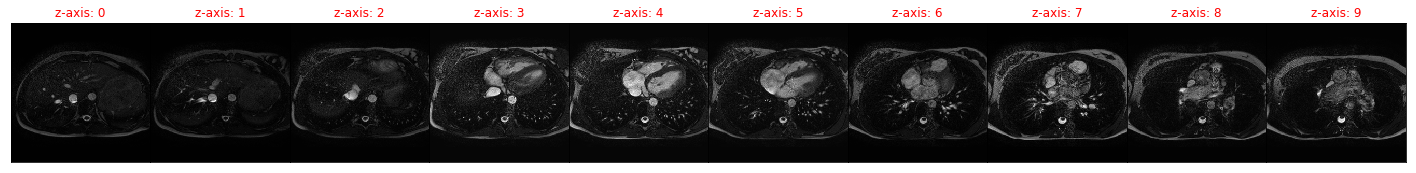

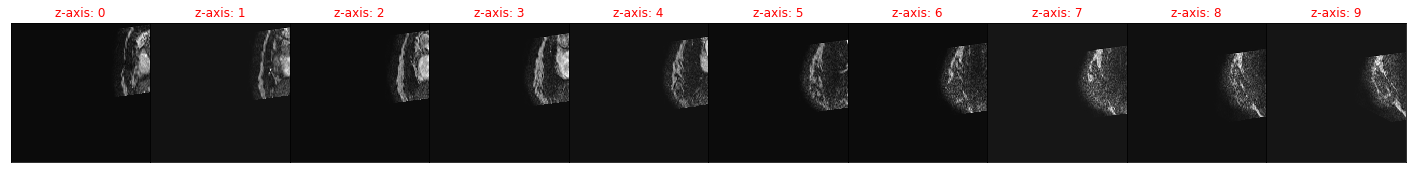

In [315]:
# get direction of sax and apply transform
sax_direction = list(reversed(sax_sitk.GetDirection()))
sax_direction = np.reshape(sax_direction,(3,3))
print(sax_direction)

ax_nda_transformed = affine_transform(ax_nda,sax_direction, offset=list(reversed(sax_sitk.GetOrigin())))
print('before transform shape: {}'.format(ax_nda.shape))
print('after transform shape: {}'.format(ax_nda_transformed.shape))
show_2D_or_3D(ax_nda[::12])
show_2D_or_3D(ax_nda_transformed[::12])
describe_sitk(ax_nda_transformed)

In [116]:
# ident transform
direction = np.identity(3)
print(direction)

ax_nda_transformed = affine_transform(ax_nda,direction)
print('before transform shape: {}'.format(ax_nda.shape))
print('after transform shape: {}'.format(ax_nda_transformed.shape))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
before transform shape: (144, 320, 319)
after transform shape: (144, 320, 319)


# 20 degree x axis rotation

[[ 1.         0.         0.       ]
 [ 0.         0.9396926 -0.3420202]
 [ 0.         0.3420202  0.9396926]]
before transform shape: (144, 320, 319)
after transform shape: (144, 512, 512)


2020-06-17 14:12:38,120 INFO size: (512, 512, 144)
2020-06-17 14:12:38,120 INFO spacing: (1.0, 1.0, 1.0)
2020-06-17 14:12:38,121 INFO origin: (0.0, 0.0, 0.0)
2020-06-17 14:12:38,121 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-17 14:12:38,122 INFO pixel type: 32-bit float
2020-06-17 14:12:38,122 INFO number of pixel components: 1


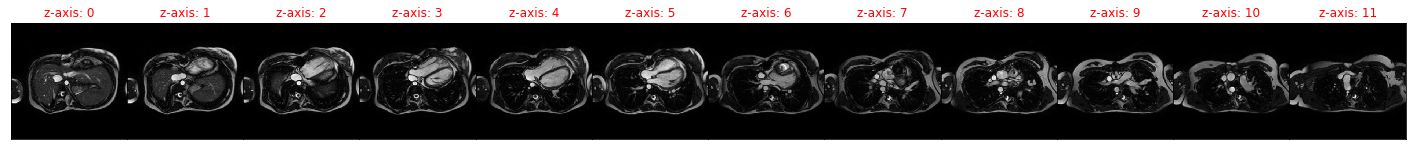

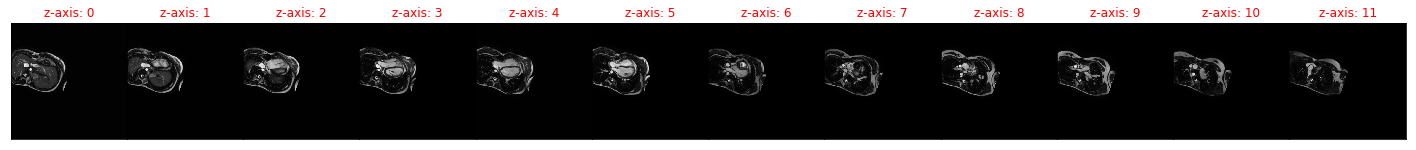

In [128]:
direction = np.array([  [1.0000000,  0.0000000,  0.0000000],
   [0.0000000,  0.9396926, -0.3420202],
   [0.0000000,  0.3420202,  0.9396926] ])
print(direction)

ax_nda_transformed = affine_transform(ax_nda,direction,offset=(0,0,0),output_shape=(144,512,512))
print('before transform shape: {}'.format(ax_nda.shape))
print('after transform shape: {}'.format(ax_nda_transformed.shape))
show_2D_or_3D(ax_nda[::12])
show_2D_or_3D(ax_nda_transformed[::12])
describe_sitk(ax_nda_transformed)

# 20 degree x axis rotation - manual offset definition

[[ 1.         0.         0.       ]
 [ 0.         0.9396926 -0.3420202]
 [ 0.         0.3420202  0.9396926]]
before transform shape: (144, 320, 319)
after transform shape: (144, 320, 319)


2020-06-17 15:50:32,472 INFO size: (319, 320, 144)
2020-06-17 15:50:32,473 INFO spacing: (1.0, 1.0, 1.0)
2020-06-17 15:50:32,473 INFO origin: (0.0, 0.0, 0.0)
2020-06-17 15:50:32,473 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-17 15:50:32,474 INFO pixel type: 32-bit float
2020-06-17 15:50:32,474 INFO number of pixel components: 1


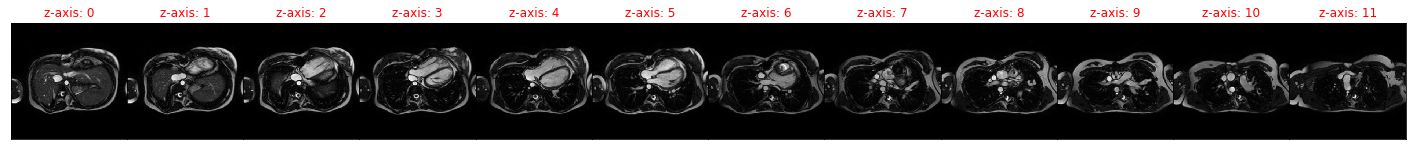

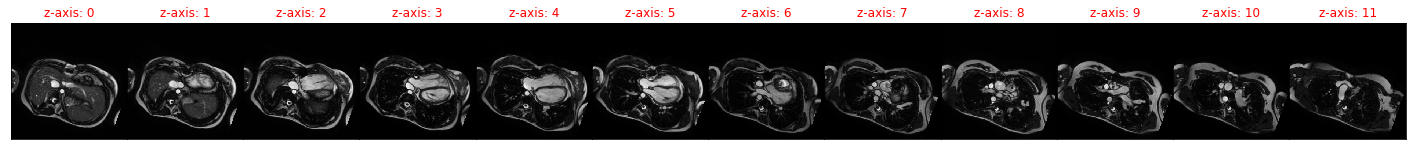

In [200]:
direction = np.array([  [1.0000000,  0.0000000,  0.0000000],
   [0.0000000,  0.9396926, -0.3420202],
   [0.0000000,  0.3420202,  0.9396926] ])
print(direction)

ax_nda_transformed = affine_transform(ax_nda,direction,offset=[  0.,35.38714952, -43.96028333])
print('before transform shape: {}'.format(ax_nda.shape))
print('after transform shape: {}'.format(ax_nda_transformed.shape))
show_2D_or_3D(ax_nda[::12])
show_2D_or_3D(ax_nda_transformed[::12])
describe_sitk(ax_nda_transformed)

# 20 degree in z rotation - manuel offset

[[ 0.9396926 -0.3420202  0.       ]
 [ 0.3420202  0.9396926  0.       ]
 [ 0.         0.         1.       ]]
before transform shape: (144, 320, 319)
after transform shape: (144, 320, 319)


2020-06-17 15:51:01,004 INFO size: (319, 320, 144)
2020-06-17 15:51:01,005 INFO spacing: (1.0, 1.0, 1.0)
2020-06-17 15:51:01,005 INFO origin: (0.0, 0.0, 0.0)
2020-06-17 15:51:01,006 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-17 15:51:01,006 INFO pixel type: 32-bit float
2020-06-17 15:51:01,006 INFO number of pixel components: 1


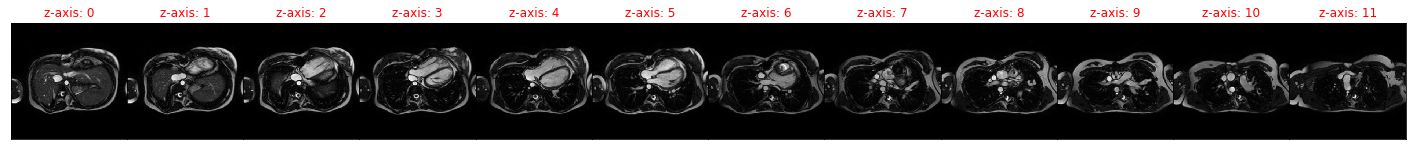

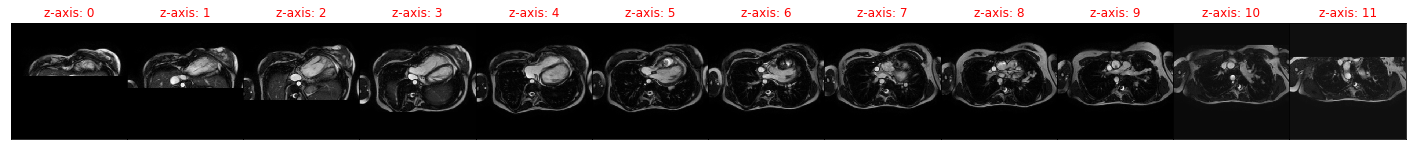

In [201]:
direction = np.reshape(np.array(
    [  0.9396926, -0.3420202,  0.0000000,
   0.3420202,  0.9396926,  0.0000000,
   0.0000000,  0.0000000,  1.0000000 ]
),(3,3))
#direction = np.linalg.inv(direction)
print(direction)

ax_nda_transformed = affine_transform(ax_nda,direction,offset=(50,0,0))
print('before transform shape: {}'.format(ax_nda.shape))
print('after transform shape: {}'.format(ax_nda_transformed.shape))
show_2D_or_3D(ax_nda[::12])
show_2D_or_3D(ax_nda_transformed[::12])
describe_sitk(ax_nda_transformed)

# rotate nda of image and mask AX --> SAX

In [63]:
def pad_to_cube(nda):
    # pad the volume into cubic format
    max_size = max(nda.shape)
    pad_with = [((max_size - nda.shape[i])//2,(max_size - nda.shape[i])//2) for i in range(nda.ndim)]
    temp = np.pad(nda,pad_width=pad_with)
    print('shape after cubic padding: {}'.format(temp.shape))
    return temp

def get_origin_as_offset(sitk_img):
    return np.array(
        list(reversed(sax_sitk.GetOrigin()))
    )

def get_direction_as_translationmatrix(sitk_img):
    
    return np.reshape(np.array(
        list(reversed(sax_sitk.GetDirection()))
    ),(3,3))
    
def apply_direction(reference_sitk, target_sitk, target_shape):
    """Apply direction from reference image to target image"""

    ref_nda = sitk.GetArrayFromImage(reference_sitk)
    target_nda = sitk.GetArrayFromImage(target_sitk)
    
    ref_nda = pad_to_cube(ref_nda)
    target_nda = pad_to_cube(target_nda)
    
    print('target image paded')
    show_2D_or_3D(target_nda[::12])
    plt.show()
    print('reference image paded')
    show_2D_or_3D(ref_nda[::12])
    plt.show()

    # calculate new offset
    orig = get_origin_as_offset(reference_sitk)
    direction = get_direction_as_translationmatrix(reference_sitk)
    print('origin: {}'.format(orig))
    print('direction: {}'.format(direction))
    
    # Apply rotation to origin
    new_orig = direction.dot(orig)
    print('new origin: {}'.format(new_orig))
    offset = new_orig - orig
    # we need to shift the offset
    offset[0]+=70
    offset[-1]+=150
    print('new - old: {}'.format(offset))
    # offset order = z, x, y
    offset_2 = [134.82032924, -55.09381123, 365.3733484 ]
    offset_extrema = (-172.04769692865386, -156.679327102261, -136.24054644617328)


    # apply affine transformation
    nda_transformed = affine_transform(target_nda, direction, offset=offset_2)
    print('before transform shape: {}'.format(target_nda.shape))
    print('after transform shape: {}'.format(nda_transformed.shape))
    print('target image')
    show_2D_or_3D(target_nda[::20])
    plt.show()
    print('transformed target image')
    show_2D_or_3D(nda_transformed[::20])
    plt.show()
    print('reference image')
    show_2D_or_3D(ref_nda[::20])
    describe_sitk(ref_nda)

    # post-process to create original shape
    # cut top and bottom along z, there is no necessary image data for these slices, we padded it for the rotation
    off = ( ax_nda.shape[0] - target_shape[0] )//2
    print('cut z by an offset of: {}'.format(off))
    temp = nda_transformed[off-20:-off+20,...]
    print(temp.shape)
    show_2D_or_3D(temp[::10])
    return temp

(270, 270, 270)
shape after cubic padding: (270, 270, 270)
[[ 0.43995171 -0.88957917 -0.12284706]
 [ 0.26894082  0.          0.9631567 ]
 [-0.85680414 -0.45678102  0.23924415]]
origin: [ -28.5240593  -117.8934288  -140.84358835]
direction: [[ 0.43995171 -0.88957917 -0.12284706]
 [ 0.26894082  0.          0.9631567 ]
 [-0.85680414 -0.45678102  0.23924415]]
(3, 3)
new origin: [ 109.62855089 -143.32573016   44.59500867]
new - old: [208.15261019 -25.43230135 285.43859702]
before transform shape: (270, 270, 270)
after transform shape: (270, 270, 270)


2020-06-18 08:36:01,286 INFO size: (270, 270, 270)
2020-06-18 08:36:01,286 INFO spacing: (1.0, 1.0, 1.0)
2020-06-18 08:36:01,287 INFO origin: (0.0, 0.0, 0.0)
2020-06-18 08:36:01,287 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2020-06-18 08:36:01,287 INFO pixel type: 32-bit float
2020-06-18 08:36:01,287 INFO number of pixel components: 1


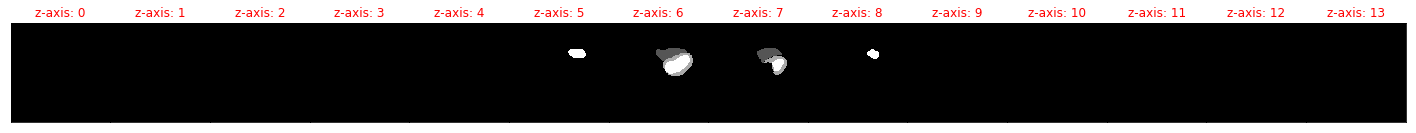

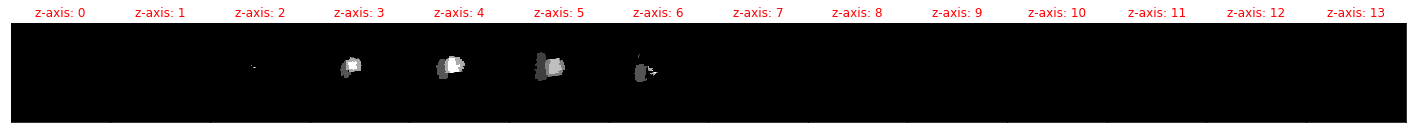

75
(160, 270, 270)


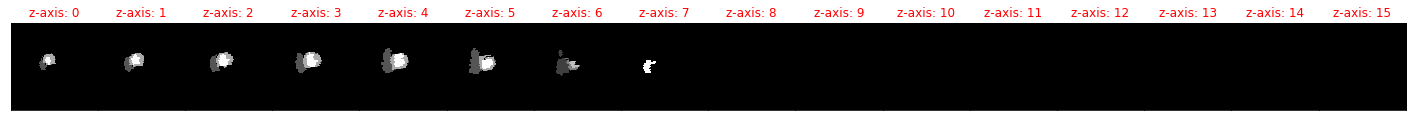

In [308]:
# apply rotation to mask

# pad the volume into cubic format
max_size = max(ax_msk_nda.shape)
temp = np.zeros((max_size,max_size, max_size))
print(temp.shape)
pad_with = [((max_size - ax_msk_nda.shape[i])//2,(max_size - ax_msk_nda.shape[i])//2) for i in range(ax_msk_nda.ndim)]
temp = np.pad(ax_msk_nda,pad_width=pad_with)
print('shape after cubic padding: {}'.format(temp.shape))
ax_msk_nda = temp
# direction of SAX
direction = np.reshape(np.array(
    list(reversed(sax_sitk.GetDirection()))),(3,3))

# calculate new offset
orig = np.array(list(reversed(ax_sitk.GetOrigin())))
print('origin: {}'.format(orig))
print('direction: {}'.format(direction))
print(direction.shape)
new_orig = direction.dot(orig)
print('new origin: {}'.format(new_orig))
offset = new_orig - orig
offset[0]+=70
offset[-1]+=100
print('new - old: {}'.format(offset))
# offset order = z 
offset_2 = [190.13496906, -34.81490344, 300.35642662]

ax_msk_nda_transformed = affine_transform(ax_msk_nda,direction,offset=offset, order=3)
print('before transform shape: {}'.format(ax_msk_nda.shape))
print('after transform shape: {}'.format(ax_msk_nda_transformed.shape))
show_2D_or_3D(ax_msk_nda[::20])
show_2D_or_3D(ax_msk_nda_transformed[::20])
describe_sitk(ax_msk_nda_transformed)
plt.show()

# cut top and bottom, there is no necessary image data for this slices, we just needed it for the rotation
off = ( ax_msk_nda.shape[0] - ax_msk_resampled.GetSize()[-1] )//2
print(off)
temp = ax_msk_nda_transformed[off-20:-off+20,...]
print(temp.shape)
show_2D_or_3D(temp[::10])

In [193]:
np.eye(4,k=-1, dtype='float32')[1:,:]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [181]:
b = np.zeros((3,4), dtype='float32')
b[:,:-1] = np.array([[ 0.35851107, -0.35462092, -0.8126091 ],
       [ 0.86575713,  0.0440564 ,  0.37527403],
       [-0.10413382, -0.87171483,  0.36716707]])
print(b)
m = b * np.array([[8.06511639],  [1.33495848], [1.33495861] ])
m

[[ 0.35851106 -0.35462093 -0.8126091   0.        ]
 [ 0.8657571   0.0440564   0.37527403  0.        ]
 [-0.10413382 -0.87171483  0.36716706  0.        ]]


array([[ 2.89143343, -2.8600591 , -6.55378678,  0.        ],
       [ 1.15574979,  0.05881347,  0.50097525,  0.        ],
       [-0.13901434, -1.16370322,  0.49015282,  0.        ]])

In [88]:
np.array([[1.33495861], [1.33495848], [8.06511639]])

array([[1.33495861],
       [1.33495848],
       [8.06511639]])

In [42]:
a = np.array([[ 0.40912941, -0.1664772,  -0.89716134],
 [ 0.90788727, -0.02421659,  0.41851435],
 [-0.09139928, -0.98574789,  0.14123481]])

In [307]:
# rotate with sitk
rotation = sitk.VersorTransform()
print('direction: {}'.format(direction))
rotation.SetMatrix(direction.flatten())
rotation.GetCenter()

direction: [[ 0.43995171 -0.88957917 -0.12284706]
 [ 0.26894082  0.          0.9631567 ]
 [-0.85680414 -0.45678102  0.23924415]]


(0.0, 0.0, 0.0)

In [90]:
ax_src = 'dein pfad zu einer axialen nrrd datei'
sax_src = 'dein pfad zu einer short axialen nrrd datei'



ax_file_path = ax_src
sax_file_path = sax_src

reader1 = sitk.ImageFileReader()
reader1.SetFileName(ax_file_path)
ax_img = reader1.Execute()

reader2 = sitk.ImageFileReader()
reader2.SetFileName(sax_file_path)
sax_img = reader2.Execute()

size = ax_img.GetSize()
spacing = ax_img.GetSpacing()
size_new = [int(s*p) for s,p in zip(size,spacing)]
size_new = tuple(size_new)

resampler = sitk.ResampleImageFilter()
resampler.SetSize(size_new)
resampler.SetOutputSpacing((1,1,1))
resampler.SetOutputOrigin(ax_img.GetOrigin())
new_img = resampler.Execute(ax_img)

#sitk_img, size=(12, 256, 256), spacing=(8, 1.25, 1.25), interpolate=sitk.sitkNearestNeighbor

ax_array = sitk.GetArrayFromImage(new_img)
#ax_img.SetDirection(sax_img.GetDirection())
direction = sax_img.GetDirection()
direction = np.reshape(direction,(3,3))

new_array = affine_transform(ax_array,direction)
new_img = sitk.GetImageFromArray(new_array)
new_img.SetOrigin(ax_img.GetOrigin())
new_img.SetDirection(sax_img.GetDirection())   

writer = sitk.ImageFileWriter()
writer.SetFileName(os.path.join(dst,os.path.basename('img_ax_new.nrrd')))
writer.Execute(new_img)

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "dein pfad zu einer axialen nrrd datei" does not exist.

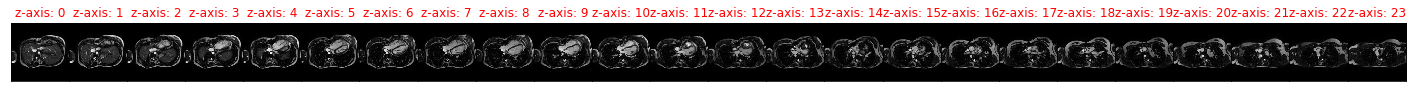

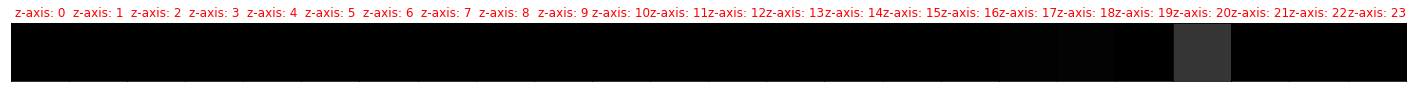

In [4]:
from src.visualization.Visualize import show_2D_or_3D
m = np.array([[ 0.47859744, -0.47340421, -6.55378698],
       [ 1.15574993,  0.05881347,  3.02662871],
       [-0.13901435, -1.16370311,  2.96124513]])
          
m   = np.reshape(m, (3,3))

img = sitk.ReadImage(chooser.selected)

nda = sitk.GetArrayFromImage(img)
show_2D_or_3D(nda)
plt.show()

nda_transform = scipy.ndimage.affine_transform(nda,m)
show_2D_or_3D(nda_transform)